In [1]:
import pandas as pd
import numpy as np
from ta import add_all_ta_features
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import step, show
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import regularizers
import urllib.request
import ssl
import json
from sklearn.impute import SimpleImputer
import time
import ray
#import datetime as dt

from random import shuffle

#from polygon import RESTClient
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
import finnhub
from datetime import datetime, timedelta
import calendar

%matplotlib inline
mpl.style.use('seaborn')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

## Get the data from finnhub

In [30]:
def get_data():
    
    # Setup client
    finnhub_client = finnhub.Client(api_key="c8ksf62ad3ibbdm43d2g")

    to_date = datetime.utcnow()
    from_date = to_date - timedelta(days=3)
    df = pd.DataFrame()
    #from_date < datetime.utcnow()
    while from_date < datetime.utcnow():
        to_date = from_date + timedelta(minutes= 1000)
        print ('From: ', from_date)
        print ('Tooo: ', to_date)
        linux_from_date = calendar.timegm(from_date.utctimetuple())
        linux_to_date = calendar.timegm(to_date.utctimetuple())
        temp_df = pd.DataFrame(finnhub_client.crypto_candles('BINANCE:BTCUSDT', '1', linux_from_date ,linux_to_date))
        temp_df.index = pd.to_datetime(temp_df['t'], unit='s')
        df = df.append(temp_df)
        from_date = to_date
        time.sleep(1)

    df['diff'] = df['c'] - df['o']
    df['%change'] = df['c'].pct_change(periods=5)
    df['gap'] = df['o'] - df['c'].shift(1)
    df['days']= df.index.day
    df['hours'] = df.index.hour
    df['minutes'] = df.index.minute
    df['returns']= np.log(df['c'].div(df['c'].shift(1)))
    df['Cdirection']=np.where(df["returns"] > 0, 1, 0)
    df['Fdirection']=df.Cdirection.shift(-1)
    df.drop(['t','s'],axis=1, inplace=True)
    df.dropna(inplace=True)
    #df = pd.get_dummies(data=df, columns=['minutes','hours', 'days'],drop_first=True)
    #Add TA
    np.seterr(divide='ignore', invalid='ignore')
    df = add_all_ta_features(df, open="o", high="h", low="l", close="c", volume="v",fillna=False)
    #deal with NaN
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer = imputer.fit_transform(df)
    df = pd.DataFrame(imputer, columns=df.columns.values, index=df.index )
    #scale the data
    data_input = df.drop(['Fdirection'],axis=1)
    scaler = StandardScaler()
    scaler.fit(data_input)
    test_scaled_inputs = scaler.transform(data_input)
    
    return df, test_scaled_inputs

In [5]:
df

,c,h,l,o,v,diff,%change,gap,days,hours,minutes,returns,Cdirection,Fdirection
t,,,,,,,,,,,,,,
2021-09-17 06:11:00,47893.22,47900.00,47885.24,47888.01,15.20564,5.21,NaN,NaN,17,6,11,NaN,0,0.0
2021-09-17 06:12:00,47891.59,47900.00,47886.68,47892.69,8.80972,-1.10,NaN,-0.53,17,6,12,-0.000034,0,1.0
2021-09-17 06:13:00,47899.00,47899.95,47887.54,47891.59,8.77518,7.41,NaN,0.00,17,6,13,0.000155,1,1.0
2021-09-17 06:14:00,47899.90,47899.94,47890.12,47897.23,11.68620,2.67,NaN,-1.77,17,6,14,0.000019,1,0.0
2021-09-17 06:15:00,47895.01,47900.00,47895.00,47899.89,9.13800,-4.88,NaN,-0.01,17,6,15,-0.000102,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-22 16:06:00,60881.98,60922.06,60838.39,60844.67,78.25064,37.31,0.002311,5.64,22,16,6,0.000706,1,0.0
2021-10-22 16:07:00,60759.52,60881.99,60732.25,60881.99,55.25340,-122.47,0.003827,0.01,22,16,7,-0.002013,0,0.0
2021-10-22 16:08:00,60680.71,60770.73,60680.70,60759.53,37.28563,-78.82,-0.000930,0.01,22,16,8,-0.001298,0,0.0


In [6]:
df.to_csv('data_50K.csv')

# read data from CSV

In [2]:
df = pd.read_csv('data_50K.csv',index_col=0,parse_dates=True)

In [3]:
df

,c,h,l,o,v,diff,%change,gap,days,hours,minutes,returns,Cdirection,Fdirection
t,,,,,,,,,,,,,,
2021-09-17 06:11:00,47893.22,47900.00,47885.24,47888.01,15.20564,5.21,NaN,NaN,17,6,11,NaN,0,0.0
2021-09-17 06:12:00,47891.59,47900.00,47886.68,47892.69,8.80972,-1.10,NaN,-0.53,17,6,12,-0.000034,0,1.0
2021-09-17 06:13:00,47899.00,47899.95,47887.54,47891.59,8.77518,7.41,NaN,0.00,17,6,13,0.000155,1,1.0
2021-09-17 06:14:00,47899.90,47899.94,47890.12,47897.23,11.68620,2.67,NaN,-1.77,17,6,14,0.000019,1,0.0
2021-09-17 06:15:00,47895.01,47900.00,47895.00,47899.89,9.13800,-4.88,NaN,-0.01,17,6,15,-0.000102,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-22 16:06:00,60881.98,60922.06,60838.39,60844.67,78.25064,37.31,0.002311,5.64,22,16,6,0.000706,1,0.0
2021-10-22 16:07:00,60759.52,60881.99,60732.25,60881.99,55.25340,-122.47,0.003827,0.01,22,16,7,-0.002013,0,0.0
2021-10-22 16:08:00,60680.71,60770.73,60680.70,60759.53,37.28563,-78.82,-0.000930,0.01,22,16,8,-0.001298,0,0.0


In [5]:
#drop NaN
df.dropna(inplace=True)
df

,c,h,l,o,v,diff,%change,gap,days,hours,minutes,returns,Cdirection,Fdirection
t,,,,,,,,,,,,,,
2021-09-17 06:16:00,47830.12,47895.02,47829.15,47895.02,28.10805,-64.90,-0.001318,0.01,17,6,16,-0.001356,0,1.0
2021-09-17 06:17:00,47857.45,47862.08,47829.16,47830.12,26.82256,27.33,-0.000713,0.00,17,6,17,0.000571,1,0.0
2021-09-17 06:18:00,47844.49,47860.18,47838.53,47857.46,10.56938,-12.97,-0.001138,0.01,17,6,18,-0.000271,0,0.0
2021-09-17 06:19:00,47829.21,47850.34,47827.00,47844.48,34.90340,-15.27,-0.001476,-0.01,17,6,19,-0.000319,0,1.0
2021-09-17 06:20:00,47850.00,47850.00,47827.88,47829.21,15.85796,20.79,-0.000940,0.00,17,6,20,0.000435,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-22 16:05:00,60839.03,60873.16,60741.56,60764.94,104.38933,74.09,0.002866,0.01,22,16,5,0.001219,1,1.0
2021-10-22 16:06:00,60881.98,60922.06,60838.39,60844.67,78.25064,37.31,0.002311,5.64,22,16,6,0.000706,1,0.0
2021-10-22 16:07:00,60759.52,60881.99,60732.25,60881.99,55.25340,-122.47,0.003827,0.01,22,16,7,-0.002013,0,0.0


## Add dummies

In [5]:
df = pd.get_dummies(data=df, columns=['minutes','hours', 'days'],drop_first=True)

In [6]:
df

,c,h,l,o,v,diff,%change,gap,returns,Cdirection,Fdirection,minutes_1,minutes_2,minutes_3,minutes_4,minutes_5,minutes_6,minutes_7,minutes_8,minutes_9,minutes_10,minutes_11,minutes_12,minutes_13,minutes_14,minutes_15,minutes_16,minutes_17,minutes_18,minutes_19,minutes_20,minutes_21,minutes_22,minutes_23,minutes_24,minutes_25,minutes_26,minutes_27,minutes_28,minutes_29,minutes_30,minutes_31,minutes_32,minutes_33,minutes_34,minutes_35,minutes_36,minutes_37,minutes_38,minutes_39,minutes_40,minutes_41,minutes_42,minutes_43,minutes_44,minutes_45,minutes_46,minutes_47,minutes_48,minutes_49,minutes_50,minutes_51,minutes_52,minutes_53,minutes_54,minutes_55,minutes_56,minutes_57,minutes_58,minutes_59,hours_1,hours_2,hours_3,hours_4,hours_5,hours_6,hours_7,hours_8,hours_9,hours_10,hours_11,hours_12,hours_13,hours_14,hours_15,hours_16,hours_17,hours_18,hours_19,hours_20,hours_21,hours_22,hours_23,days_2,days_3,days_4,days_5,days_6,days_7,days_8,days_9,days_10,days_11,days_12,days_13,days_14,days_15,days_16,days_17,days_18,days_19,days_20,days_21,days_22,days_23,days_24,days_25,days_26,days_27,days_28,days_29,days_30
t,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-09-17 06:16:00,47830.12,47895.02,47829.15,47895.02,28.10805,-64.90,-0.001318,0.01,-0.001356,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-09-17 06:17:00,47857.45,47862.08,47829.16,47830.12,26.82256,27.33,-0.000713,0.00,0.000571,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-09-17 06:18:00,47844.49,47860.18,47838.53,47857.46,10.56938,-12.97,-0.001138,0.01,-0.000271,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-09-17 06:19:00,47829.21,47850.34,47827.00,47844.48,34.90340,-15.27,-0.001476,-0.01,-0.000319,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-09-17 06:20:00,47850.00,47850.00,47827.88,47829.21,15.85796,20.79,-0.000940,0.00,0.000435,1,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-22 16:05:00,60839.03,60873.16,60741.56,60764.94,104.38933,74.09,0.002866,0.01,0.001219,1,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2021-10-22 16:06:00,60881.98,60922.06,60838.39,60844.67,78.25064,37.31,0.002311,5.64,0.000706,1,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0

# Add TA

In [6]:
np.seterr(divide='ignore', invalid='ignore')
df = add_all_ta_features(df, open="o", high="h", low="l", close="c", volume="v",fillna=False)

In [7]:
df

,c,h,l,o,v,diff,%change,gap,days,hours,minutes,returns,Cdirection,Fdirection,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
t,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-09-17 06:16:00,47830.12,47895.02,47829.15,47895.02,28.10805,-64.90,-0.001318,0.01,17,6,16,-0.001356,0,1.0,-27.280213,28.108050,NaN,NaN,NaN,NaN,-1.965175,NaN,NaN,1000.000000,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,47917.300000,47785.560000,NaN,0.338242,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47862.085,NaN,0.000000,0.000000,0.000000,NaN,51425.625574,51414.474707,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.995624,NaN,0.000000
2021-09-17 06:17:00,47857.45,47862.08,47829.16,47830.12,26.82256,27.33,-0.000713,0.00,17,6,17,0.000571,1,0.0,-8.002517,54.930610,NaN,NaN,-2.020791e+09,NaN,-1.951007,NaN,NaN,1000.571397,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,47899.891667,47801.101667,NaN,0.570385,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47862.085,NaN,0.000000,0.000000,0.000000,NaN,51425.625574,51414.474707,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.057140,0.057123,0.057140
2021-09-17 06:18:00,47844.49,47860.18,47838.53,47857.46,10.56938,-12.97,-0.001138,0.01,17,6,18,-0.000271,0,0.0,-12.752635,44.361230,NaN,NaN,7.650662e+08,NaN,0.012464,NaN,NaN,1000.300438,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,47889.722222,47809.428889,NaN,0.436663,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47862.085,NaN,0.000000,0.000000,0.000000,NaN,51425.625574,51414.474707,NaN,NaN,NaN,NaN,47895.020000,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.027080,-0.027084,0.030044
2021-09-17 06:19:00,47829.21,47850.34,47827.00,47844.48,34.90340,-15.27,-0.001476,-0.01,17,6,19,-0.000319,0,1.0,-41.046222,9.457830,NaN,NaN,-7.145089e+08,NaN,-0.014009,NaN,NaN,1000.300438,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,47882.005833,47810.115833,NaN,0.265603,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47861.010,NaN,0.000000,0.000000,0.000000,NaN,51425.625574,51414.474707,NaN,NaN,NaN,NaN,47893.890200,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.031937,-0.031942,-0.001903
2021-09-17 06:20:00,47850.00,47850.00,47827.88,47829.21,15.85796,20.79,-0.000940,0.00,17,6,20,0.000435,1,1.0,-25.188262,25.315790,NaN,NaN,3.766184e+07,NaN,-0.004254,NaN,NaN,1000.735241,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,

# Deal with NaN

In [8]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit_transform(df)
  
df = pd.DataFrame(imputer, columns=df.columns.values, index=df.index )

df

,c,h,l,o,v,diff,%change,gap,days,hours,minutes,returns,Cdirection,Fdirection,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
t,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-09-17 06:16:00,47830.12,47895.02,47829.15,47895.02,28.10805,-64.90,-0.001318,0.01,17.0,6.0,16.0,-0.001356,0.0,1.0,-27.280213,28.108050,-0.004594,52.402066,1.143936e+08,1.150354e+08,-1.965175,51426.624266,49.957063,1000.000000,51426.747232,51568.989178,51284.505286,0.560105,0.503022,0.0,0.0,51427.191803,47917.300000,47785.560000,0.244260,0.338242,0.0,0.0,51268.168338,51581.321832,51424.745085,0.615553,0.505823,0.000000,0.223868,1.788569,1.794153,-0.005980,51427.198241,51426.405359,51427.196949,51426.390413,1.003833,0.997137,0.006696,0.000474,24.930979,-0.377637,0.095715,0.091028,0.004686,51426.538417,51423.522428,51425.625574,47862.085,49.236657,0.000000,0.000000,0.000000,1.121703,51425.625574,51414.474707,51.399646,50.317247,1.082399,51339.023454,51512.387348,0.0,0.0,50.374335,0.498960,0.498963,0.498960,0.796455,49.956956,50.376093,50.375757,-49.623907,3.683065,0.006191,0.003201,0.003211,-0.000010,-2.129672,-2.130154,0.000795,51427.661335,-6.995624,0.000465,0.000000
2021-09-17 06:17:00,47857.45,47862.08,47829.16,47830.12,26.82256,27.33,-0.000713,0.00,17.0,6.0,17.0,0.000571,1.0,0.0,-8.002517,54.930610,-0.004594,52.402066,-2.020791e+09,1.150354e+08,-1.951007,51426.624266,49.957063,1000.571397,51426.747232,51568.989178,51284.505286,0.560105,0.503022,0.0,0.0,51427.191803,47899.891667,47801.101667,0.244260,0.570385,0.0,0.0,51268.168338,51581.321832,51424.745085,0.615553,0.505823,0.000000,0.223868,1.788569,1.794153,-0.005980,51427.198241,51426.405359,51427.196949,51426.390413,1.003833,0.997137,0.006696,0.000474,24.930979,-0.377637,0.095715,0.091028,0.004686,51426.538417,51423.522428,51425.625574,47862.085,49.236657,0.000000,0.000000,0.000000,1.121703,51425.625574,51414.474707,51.399646,50.317247,1.082399,51339.023454,51512.387348,0.0,0.0,50.374335,0.498960,0.498963,0.498960,0.796455,49.956956,50.376093,50.375757,-49.623907,3.683065,0.006191,0.003201,0.003211,-0.000010,-2.129672,-2.130154,0.000795,51427.661335,0.057140,0.057123,0.057140
2021-09-17 06:18:00,47844.49,47860.18,47838.53,47857.46,10.56938,-12.97,-0.001138,0.01,17.0,6.0,18.0,-0.000271,0.0,0.0,-12.752635,44.361230,-0.004594,52.402066,7.650662e+08,1.150354e+08,0.012464,51426.624266,49.957063,1000.300438,51426.747232,51568.989178,51284.505286,0.560105,0.503022,0.0,0.0,51427.191803,47889.722222,47809.428889,0.244260,0.436663,0.0,0.0,51268.168338,51581.321832,51424.745085,0.615553,0.505823,0.000000,0.223868,1.788569,1.794153,-0.005980,51427.198241,51426.405359,51427.196949,51426.390413,1.003833,0.997137,0.006696,0.0004

# Data Analysis

In [9]:
data = df.copy()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Fdirection', ylabel='count'>

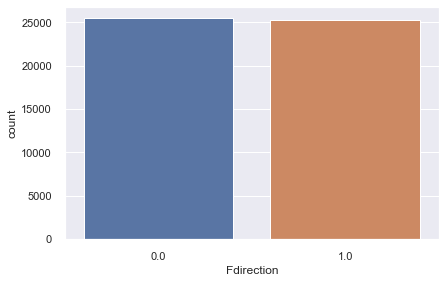

In [10]:
sns.set(rc={'figure.figsize':(6.7,4.27)})
sns.countplot(data['Fdirection'])

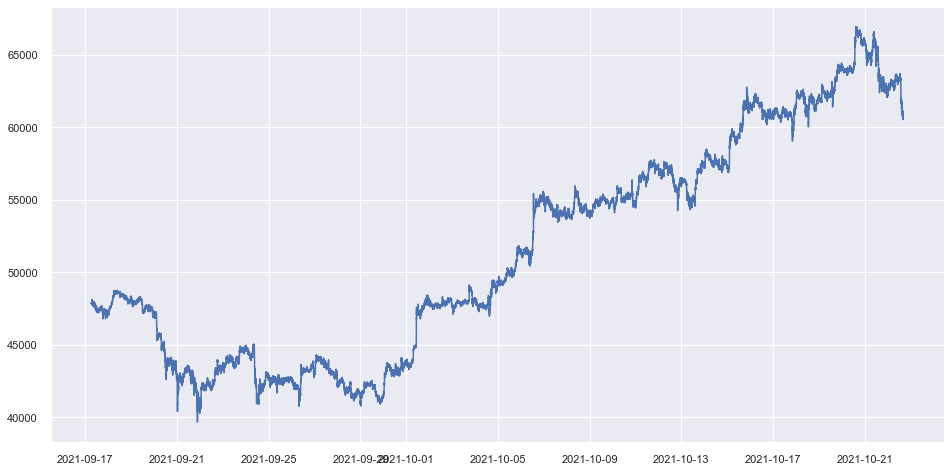

In [11]:
plt.figure(figsize=(16,8))
plt.plot(data['c'])

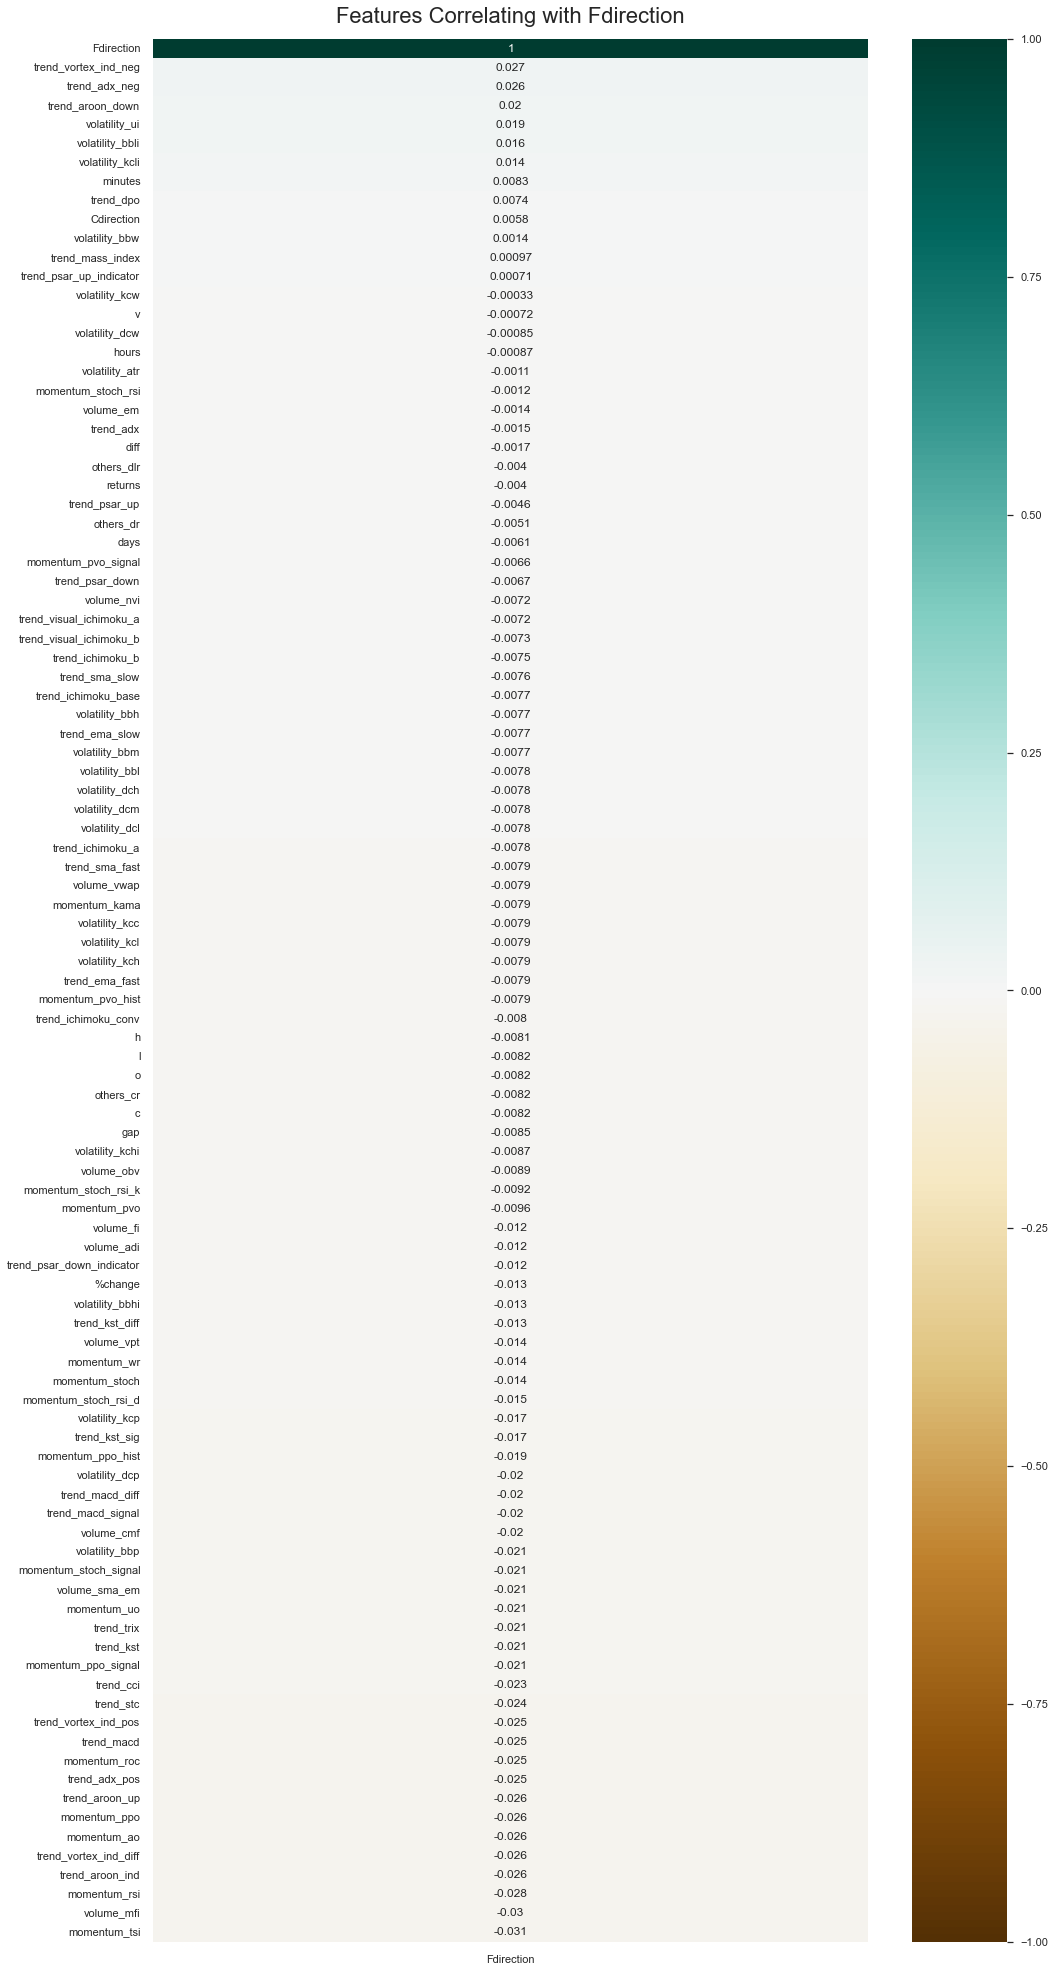

In [12]:
plt.figure(figsize=(16, 35))
heatmap = sns.heatmap(data.corr()[['Fdirection']].sort_values(by='Fdirection', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Fdirection', fontdict={'fontsize':22}, pad=16);

# Standardize Data

In [13]:
targets = np.array(data['Fdirection'].values.astype(int))
data_input = data.drop(['Fdirection'],axis=1)

In [31]:
#data_input = new_df

In [14]:
scaler = StandardScaler()
scaler.fit(data_input)
scaled_inputs = scaler.transform(data_input)

In [15]:
scaled_inputs.shape

(50874, 99)

In [16]:
test_scaled_inputs.shape

NameError: name 'test_scaled_inputs' is not defined

# Prepare Windows

In [17]:
X , Y = None, None
X = []
Y = []

In [18]:
window = 20
for i in range (window,scaled_inputs.shape[0]):
    X.append(scaled_inputs[i-window:i])
    Y.append(targets[i-1])

# Split test-train

In [19]:
X , Y = np.array(X) , np.array(Y)

In [37]:
x_train, x_test, y_train, y_test = None, None,None, None

In [20]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2,shuffle=True)

In [21]:
x_train.shape

(40683, 20, 99)

In [22]:
x_test.shape

(10171, 20, 99)

## Train

In [23]:
model = None
model = Sequential()

In [24]:
#model.add(Conv1D(filters=32, activation ='tanh', kernel_size=5, strides=1, padding="causal", input_shape=(x_train.shape[1],x_train.shape[2])))
#model.add(Conv1D(filters=32, activation ='tanh', kernel_size=5, strides=1, padding="causal"))
#model.add(Conv1D(filters=32, activation ='tanh', kernel_size=5, strides=1, padding="causal"))

#model.add(LSTM(32, return_sequences = True, stateful=False))
model.add(Bidirectional(LSTM(128,return_sequences = False),input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dropout(0.2))
model.add(BatchNormalization())
#model.add(Bidirectional(LSTM(128, return_sequences = False),input_shape=(x_train.shape[1],x_train.shape[2])))
# model.add(Dense(32,activation='tanh'))
# model.add(Dense(16,activation='tanh'))
#model.add(TimeDistributed(Dense(1, activation='sigmoid')))

#model.add(LSTM(128,input_shape=(x_train.shape[1],x_train.shape[2]), return_sequences = True, stateful=False))
# model.add(Dropout(0.3))
# model.add(BatchNormalization())
#model.add(LSTM(32,stateful=False, return_sequences = True, activation='sigmoid'))
#model.add(Dropout(0.3))
#model.add(LSTM(64,stateful=True, return_sequences = True))
#model.add(Dropout(0.4))
# model.add(LSTM(32, input_shape=(x_train.shape[1],x_train.shape[2]), stateful=False, activation ='sigmoid'))
# model.add(Dropout(0.3))
# model.add(BatchNormalization())

#model.add(Dense(32,activation='tanh'))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))
model.add(Dense(16))
model.add(Dropout(0.2))
model.add(Dense(8))
#model.add(Dense(4,activation='tanh'))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              233472    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 16)                4112      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 1

In [26]:
adm = Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy', optimizer=adm, metrics=['accuracy'])

In [29]:
hist = model.fit(x_train,y_train, epochs=15, verbose=1,shuffle=True, validation_split=0.2) #, callbacks=[es_cb,lr_cb])

Epoch 1/15
1018/1018 [==============================] - 19s 19ms/step - loss: 0.6800 - accuracy: 0.5634 - val_loss: 0.7033 - val_accuracy: 0.5065
Epoch 2/15
1018/1018 [==============================] - 19s 19ms/step - loss: 0.6788 - accuracy: 0.5640 - val_loss: 0.7035 - val_accuracy: 0.5083
Epoch 3/15
1018/1018 [==============================] - 19s 18ms/step - loss: 0.6749 - accuracy: 0.5738 - val_loss: 0.7014 - val_accuracy: 0.5049
Epoch 4/15
1018/1018 [==============================] - 19s 18ms/step - loss: 0.6689 - accuracy: 0.5825 - val_loss: 0.7134 - val_accuracy: 0.5078
Epoch 5/15
1018/1018 [==============================] - 19s 18ms/step - loss: 0.6642 - accuracy: 0.5925 - val_loss: 0.7137 - val_accuracy: 0.5049
Epoch 6/15
1018/1018 [==============================] - 19s 18ms/step - loss: 0.6565 - accuracy: 0.6062 - val_loss: 0.7197 - val_accuracy: 0.5158
Epoch 7/15
1018/1018 [==============================] - 19s 19ms/step - loss: 0.6489 - accuracy: 0.6143 - val_loss: 0.7233 -

# Evaluate

In [28]:
score, acc = model.evaluate(x_test, y_test)

318/318 [==============================] - 2s 7ms/step - loss: 0.6947 - accuracy: 0.5161


## Drop unimportant Features

In [39]:
def var_importance(model):
    
    df = pd.DataFrame(columns=['Feature','Effect']) 
    #x = x_test
    new_input = data_input.copy()
    #print(x_test.shape)
    #x = np.concatenate([next(g)[0] for _ in range(50)]) # Get a sample of data
    orig_out = model.predict(x_test)
    for i in range(x_test.shape[2]):  # iterate over the three features
        new_x = x_test.copy()
        perturbation = np.random.normal(0.0, 0.2, size=new_x.shape[:2])
        new_x[:, :, i] = new_x[:, :, i] + perturbation
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5
        print ('Feature: {}, perturbation effect: {}'.format(data_input.columns[i], effect))
        df = df.append({'Feature': data_input.columns[i], 'Effect': effect}, ignore_index=True)
        
        if effect < 0.01:
            new_input.drop(data_input.columns[i], axis=1,inplace=True)
            print('Deleting column: {}'.format(data_input.columns[i]))
            
        perturbation = None
        new_x = None
        perturbed_out= None
        effect = None
        
    return new_input, df

In [47]:
# @ray.remote
# def study_feature(i):
#     new_x = ray.put(x_test.copy())
#     perturbation = np.random.normal(0.0, 0.2, size=new_x.shape[:2])
#     new_x[:, :, i] = new_x[:, :, i] + perturbation
#     perturbed_out = model.predict(new_x)
#     effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5
#     print ('Feature: {}, perturbation effect: {}'.format(data_input.columns[i], effect))
#     df = df.append({'Feature': data_input.columns[i], 'Effect': effect}, ignore_index=True)
#     if effect < 0.01:
#           try:
#             new_input.drop(data_input.columns[i], axis=1,inplace=True)
#             col_to_drop.append(data_input.columns[i])
#             print('Deleting column: {}'.format(data_input.columns[i]))
#           except Exception as e:
#             print (e)
            
#     perturbation = None
#     new_x = None
#     perturbed_out= None
#     effect = None   
  

In [48]:
# df = pd.DataFrame(columns=['Feature','Effect']) 
# new_input = data_input.copy()
# orig_out = model.predict(x_test)
# col_to_drop = []

# def var_importance(model):
#     result_ids = []
#     for i in range(x_test.shape[2]):  # iterate over the three features
#         result_ids.append(study_feature.remote(i))
        
#     ray.get(result_ids)
                
#     return new_input, df

In [40]:
new_df, stats = var_importance(model)
new_df

Feature: c, perturbation effect: 0.0028450150884595667
Deleting column: c
Feature: h, perturbation effect: 0.002725149097814267
Deleting column: h
Feature: l, perturbation effect: 0.002952279647752274
Deleting column: l
Feature: o, perturbation effect: 0.0027724322788445143
Deleting column: o
Feature: v, perturbation effect: 0.0066479070834079435
Deleting column: v
Feature: diff, perturbation effect: 0.006643296383319056
Deleting column: diff
Feature: %change, perturbation effect: 0.006973771070767948
Deleting column: %change
Feature: gap, perturbation effect: 0.007841353109945888
Deleting column: gap
Feature: returns, perturbation effect: 0.00682581237917687
Deleting column: returns
Feature: Cdirection, perturbation effect: 0.0128590768510687
Feature: minutes_1, perturbation effect: 0.00697946194995734
Deleting column: minutes_1
Feature: minutes_2, perturbation effect: 0.006813371027050135
Deleting column: minutes_2
Feature: minutes_3, perturbation effect: 0.006422394056604635
Deletin

Feature: days_4, perturbation effect: 0.00512487061956864
Deleting column: days_4
Feature: days_5, perturbation effect: 0.00559797173178053
Deleting column: days_5
Feature: days_6, perturbation effect: 0.005482365006820182
Deleting column: days_6
Feature: days_7, perturbation effect: 0.0059115027000067166
Deleting column: days_7
Feature: days_8, perturbation effect: 0.0051211365987633125
Deleting column: days_8
Feature: days_9, perturbation effect: 0.004897279653124892
Deleting column: days_9
Feature: days_10, perturbation effect: 0.005547180102853522
Deleting column: days_10
Feature: days_11, perturbation effect: 0.005532783443867965
Deleting column: days_11
Feature: days_12, perturbation effect: 0.005438592165148825
Deleting column: days_12
Feature: days_13, perturbation effect: 0.006148184695542772
Deleting column: days_13
Feature: days_14, perturbation effect: 0.005972910285012201
Deleting column: days_14
Feature: days_15, perturbation effect: 0.0056970578401548625
Deleting column:

Feature: trend_aroon_ind, perturbation effect: 0.004659196540092532
Deleting column: trend_aroon_ind
Feature: trend_psar_up, perturbation effect: 0.004273516447951916
Deleting column: trend_psar_up
Feature: trend_psar_down, perturbation effect: 0.00432614947039021
Deleting column: trend_psar_down
Feature: trend_psar_up_indicator, perturbation effect: 0.007588626898036299
Deleting column: trend_psar_up_indicator
Feature: trend_psar_down_indicator, perturbation effect: 0.007359134380024742
Deleting column: trend_psar_down_indicator
Feature: momentum_rsi, perturbation effect: 0.0040691286059937265
Deleting column: momentum_rsi
Feature: momentum_stoch_rsi, perturbation effect: 0.00496157254743067
Deleting column: momentum_stoch_rsi
Feature: momentum_stoch_rsi_k, perturbation effect: 0.004447597773719768
Deleting column: momentum_stoch_rsi_k
Feature: momentum_stoch_rsi_d, perturbation effect: 0.00511308000059844
Deleting column: momentum_stoch_rsi_d
Feature: momentum_tsi, perturbation effec

,Cdirection
t,
2021-09-17 06:16:00,0.0
2021-09-17 06:17:00,1.0
2021-09-17 06:18:00,0.0
2021-09-17 06:19:00,0.0
2021-09-17 06:20:00,1.0
...,...
2021-10-22 16:05:00,1.0
2021-10-22 16:06:00,1.0
2021-10-22 16:07:00,0.0


In [30]:
stats.sort_values('Effect',ascending=False)

,Feature,Effect
9,Cdirection,0.016667
7,gap,0.012262
185,trend_psar_down_indicator,0.012120
125,volume_em,0.011076
127,volume_vpt,0.010995
184,trend_psar_up_indicator,0.010941
21,minutes_12,0.010807
53,minutes_44,0.010794
19,minutes_10,0.010765
43,minutes_34,0.010698


## Check model predictions

In [31]:
test_df, test_scaled_inputs = get_data()

From:  2022-03-15 09:50:43.392329
Tooo:  2022-03-16 02:30:43.392329


SSLError: HTTPSConnectionPool(host='finnhub.io', port=443): Max retries exceeded with url: /api/v1//crypto/candle?token=c8ksf62ad3ibbdm43d2g&symbol=BINANCE%3ABTCUSDT&resolution=1&from=1647337843&to=1647397843&format=json (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1129)')))

In [38]:
test_df

,c,h,l,o,v,diff,%change,gap,returns,Cdirection,Fdirection,minutes_1,minutes_2,minutes_3,minutes_4,minutes_5,minutes_6,minutes_7,minutes_8,minutes_9,minutes_10,minutes_11,minutes_12,minutes_13,minutes_14,minutes_15,minutes_16,minutes_17,minutes_18,minutes_19,minutes_20,minutes_21,minutes_22,minutes_23,minutes_24,minutes_25,minutes_26,minutes_27,minutes_28,minutes_29,minutes_30,minutes_31,minutes_32,minutes_33,minutes_34,minutes_35,minutes_36,minutes_37,minutes_38,minutes_39,minutes_40,minutes_41,minutes_42,minutes_43,minutes_44,minutes_45,minutes_46,minutes_47,minutes_48,minutes_49,minutes_50,minutes_51,minutes_52,minutes_53,minutes_54,minutes_55,minutes_56,minutes_57,minutes_58,minutes_59,hours_1,hours_2,hours_3,hours_4,hours_5,hours_6,hours_7,hours_8,hours_9,hours_10,hours_11,hours_12,hours_13,hours_14,hours_15,hours_16,hours_17,hours_18,hours_19,hours_20,hours_21,hours_22,hours_23,days_2,days_3,days_4,days_5,days_6,days_7,days_8,days_9,days_10,days_11,days_12,days_13,days_14,days_15,days_16,days_17,days_18,days_19,days_20,days_21,days_22,days_23,days_24,days_25,days_26,days_27,days_28,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
t,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-02-16 08:26:00,44316.76,44321.52,44305.09,44307.76,25.53912,9.00,0.000187,-1.30,0.000174,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.741042,25.53912,-0.014132,31.608585,3.476594e+07,3.510469e+07,2.884458,39819.636107,49.464406,1000.000000,39819.437893,39933.925026,39704.950759,0.577459,0.499312,0.0,0.0,39820.204769,44330.886667,44298.026667,0.238813,0.570095,0.0,0.0,39693.722178,39945.780924,39819.751551,0.635608,0.501193,0.000000,0.235371,-0.591956,-0.589024,0.001893,39819.916387,39819.080865,39819.918993,39819.083374,0.999922,1.002172,-0.002249,-0.000195,24.906900,0.123811,0.002849,0.012331,-0.009481,39820.355534,39819.53569,39819.078767,44313.305,50.437180,0.000000,0.000000,0.000000,-0.184908,39819.078767,39824.097637,50.166732,50.040722,0.126011,39725.865320,39916.158668,0.0,0.0,49.808756,0.504040,0.504023,0.504008,-0.389482,49.623122,50.061289,50.061469,-49.938711,-1.214152,-0.001730,-0.001518,-0.001511,0.000004,-2.892171,-2.891799,0.001918,39818.913205,11.

In [34]:
test_scaled_inputs.shape

(43195, 205)

In [67]:
scaled_inputs.shape

(50874, 32)

In [64]:
test_df['prediction'] = np.nan
test_df

,c,h,l,o,v,diff,%change,gap,returns,Cdirection,Fdirection,minutes_1,minutes_2,minutes_3,minutes_4,minutes_5,minutes_6,minutes_7,minutes_8,minutes_9,minutes_10,minutes_11,minutes_12,minutes_13,minutes_14,minutes_15,minutes_16,minutes_17,minutes_18,minutes_19,minutes_20,minutes_21,minutes_22,minutes_23,minutes_24,minutes_25,minutes_26,minutes_27,minutes_28,minutes_29,minutes_30,minutes_31,minutes_32,minutes_33,minutes_34,minutes_35,minutes_36,minutes_37,minutes_38,minutes_39,minutes_40,minutes_41,minutes_42,minutes_43,minutes_44,minutes_45,minutes_46,minutes_47,minutes_48,minutes_49,minutes_50,minutes_51,minutes_52,minutes_53,minutes_54,minutes_55,minutes_56,minutes_57,minutes_58,minutes_59,hours_1,hours_2,hours_3,hours_4,hours_5,hours_6,hours_7,hours_8,hours_9,hours_10,hours_11,hours_12,hours_13,hours_14,hours_15,hours_16,hours_17,hours_18,hours_19,hours_20,hours_21,hours_22,hours_23,days_2,days_3,days_4,days_5,days_6,days_7,days_8,days_9,days_10,days_11,days_12,days_13,days_14,days_15,days_16,days_17,days_18,days_19,days_20,days_21,days_22,days_23,days_24,days_25,days_26,days_27,days_28,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,prediction
t,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-02-16 07:53:00,44113.38,44115.00,44101.30,44104.66,8.56219,8.72,0.000472,0.00,0.000198,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.537263,8.56219,-0.013910,31.687687,3.536409e+07,3.551977e+07,0.923138,39822.429927,49.482652,1000.000000,39822.220963,39936.711133,39707.730793,0.577453,0.499441,0.0,0.0,39822.993125,44123.593333,44096.193333,0.238828,0.627251,0.0,0.0,39696.502854,39948.55912,39822.530987,0.635580,0.501326,0.000000,0.235288,-0.564870,-0.566964,-0.004236,39822.706391,39821.855413,39822.703924,39821.849039,1.000100,1.002008,-0.001909,-0.000192,24.905526,0.125672,0.004731,0.014122,-0.009391,39823.14305,39822.3051,39821.861272,44108.150,50.458941,0.000000,0.000000,0.000000,-0.141935,39821.861272,39826.766505,50.193417,50.005328,0.188089,39731.636016,39915.960270,0.0,0.0,49.828595,0.503794,0.503802,0.503803,-0.373173,49.630369,50.076019,50.076261,-49.923981,-1.193909,-0.001621,-0.001454,-0.001458,-0.000010,-2.898648,-2.901209,-0.000601,39821.70

In [65]:
print (window)

20


In [66]:
for i in range (window,test_scaled_inputs.shape[0]):
    bb = test_scaled_inputs[i-window:i]
    bb = bb.reshape(1, window, test_scaled_inputs.shape[1])
    bb = model.predict(bb)
    print (bb[0].astype(float))
    test_df.iloc[i-1,-1] = bb[0].astype(float)

ValueError: in user code:

    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 20, 32), found shape=(None, 20, 205)


In [ ]:
pd.options.display.float_format = '{:,.6f}'.format

In [ ]:
test_df[['returns','Cdirection','gap','diff','Fdirection','prediction']][0:100]